#DATA 410 Lecture 20 - Spring 2022

<font face="Chalkboard" color="darkgreen" size=10>Variable Selections and Multivariate Analysis</font>

In [1]:
!pip install pyswarms

You should consider upgrading via the 'c:\users\mnelk\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
!pip install --upgrade statsmodels==0.13.2

In [3]:
import pyswarms as ps

In [6]:
#!pip install numba
#from numba import jit, prange

  Using cached numba-0.55.1-cp39-cp39-win_amd64.whl (2.4 MB)
  Using cached llvmlite-0.38.0-cp39-cp39-win_amd64.whl (23.2 MB)


ImportError: Numba needs NumPy 1.21 or less

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

In [28]:
# general imports
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error
#from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE

## Example for Square Root Lasso (based on the statsmodels library)

### Step 1: Data Import

In [15]:
df = pd.read_csv('Data/Boston_Housing_Prices.csv')
features = ['crime','rooms','residential','industrial','nox','older','distance','highway','tax','ptratio','lstat']
X = np.array(df[features])
y = np.array(df['cmedv']).reshape(-1,1)
Xdf = df[features]

In [16]:
df[features]

,crime,rooms,residential,industrial,nox,older,distance,highway,tax,ptratio,lstat
0,0.00632,6.575,18.0,2.31,0.538,65.199997,4.0900,1,296,15.300000,4.98
1,0.02731,6.421,0.0,7.07,0.469,78.900002,4.9671,2,242,17.799999,9.14
2,0.02729,7.185,0.0,7.07,0.469,61.099998,4.9671,2,242,17.799999,4.03
3,0.03237,6.998,0.0,2.18,0.458,45.799999,6.0622,3,222,18.700001,2.94
4,0.06905,7.147,0.0,2.18,0.458,54.200001,6.0622,3,222,18.700001,5.33
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,6.593,0.0,11.93,0.573,69.099998,2.4786,1,273,21.000000,9.67
502,0.04527,6.120,0.0,11.93,0.573,76.699997,2.2875,1,273,21.000000,9.08
503,0.06076,6.976,0.0,11.93,0.573,91.000000,2.1675,1,273,21.000000,5.64
504,0.10959,6.794,0.0,11.93,0.573,89.300003,2.3889,1,273,21.000000,6.48


In [52]:
scale = StandardScaler()
xs = scale.fit_transform(X)

model = sm.OLS(y,X)
result = model.fit_regularized(method='sqrt_lasso', alpha=0.1, profile_scale=True)
beta_hat = result.params
print(beta_hat)

TypeError: object of type 'StandardScaler' has no len()

In [ ]:
scale = StandardScaler()
poly = PolynomialFeatures(degree=2)

def DoKFold_SK(X,y,model,k):
  PE = []
  kf = KFold(n_splits=k,shuffle=True,random_state=1234)
  pipe = Pipeline([('Scale Data by z-scores',scale),('Polynomial Features',poly),('Regression Model',model)])
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    y_test  = y[idxtest]
    pipe.fit(X_train,y_train)
    yhat_test = pipe.predict(X_test)
    PE.append(MSE(y_test,yhat_test))
  return np.mean(PE)

In [53]:
model = Lasso(alpha=0.05,max_iter=5000)
DoKFold_SK(X,y,model,10)

13.072864845925285

In [54]:
model = Ridge(alpha=10)
DoKFold_SK(X,y,model,10)

12.440849940902206

In [55]:
model = ElasticNet(alpha=0.05,l1_ratio=0.25,max_iter=12000)
DoKFold_SK(X,y,model,10)

12.627459350544342

For SQRT Lasso, the proposed best alpha is:
$$norminv(1-\frac{0.01}{2p}) \cdot \frac{1}{\sqrt{n}}$$

In [56]:
def DoKFoldSqrtLasso(X,y,alpha,k):
  PE = []
  kf = KFold(n_splits=k,shuffle=True,random_state=1234)
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    # we create polynomial features
    X_train_poly = poly.fit_transform(X_train)
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    X_test_poly = poly.fit_transform(X_test)
    y_test  = y[idxtest]
    model = sm.OLS(y_train,X_train_poly)
    result = model.fit_regularized(method='sqrt_lasso', alpha=alpha)
    yhat_test = result.predict(X_test_poly)
    PE.append(MSE(y_test,yhat_test))
  return np.mean(PE)

In [57]:
DoKFoldSqrtLasso(X,y,0.9,10)

14.104491920820683

0.1
0.35789473684210527
0.6157894736842106
0.8736842105263158
1.1315789473684212
1.3894736842105266
1.6473684210526318
1.905263157894737
2.1631578947368424
2.421052631578948
2.678947368421053
2.936842105263158
3.1947368421052635
3.452631578947369
3.710526315789474
3.9684210526315793
4.226315789473684
4.484210526315789
4.742105263157895
5.0


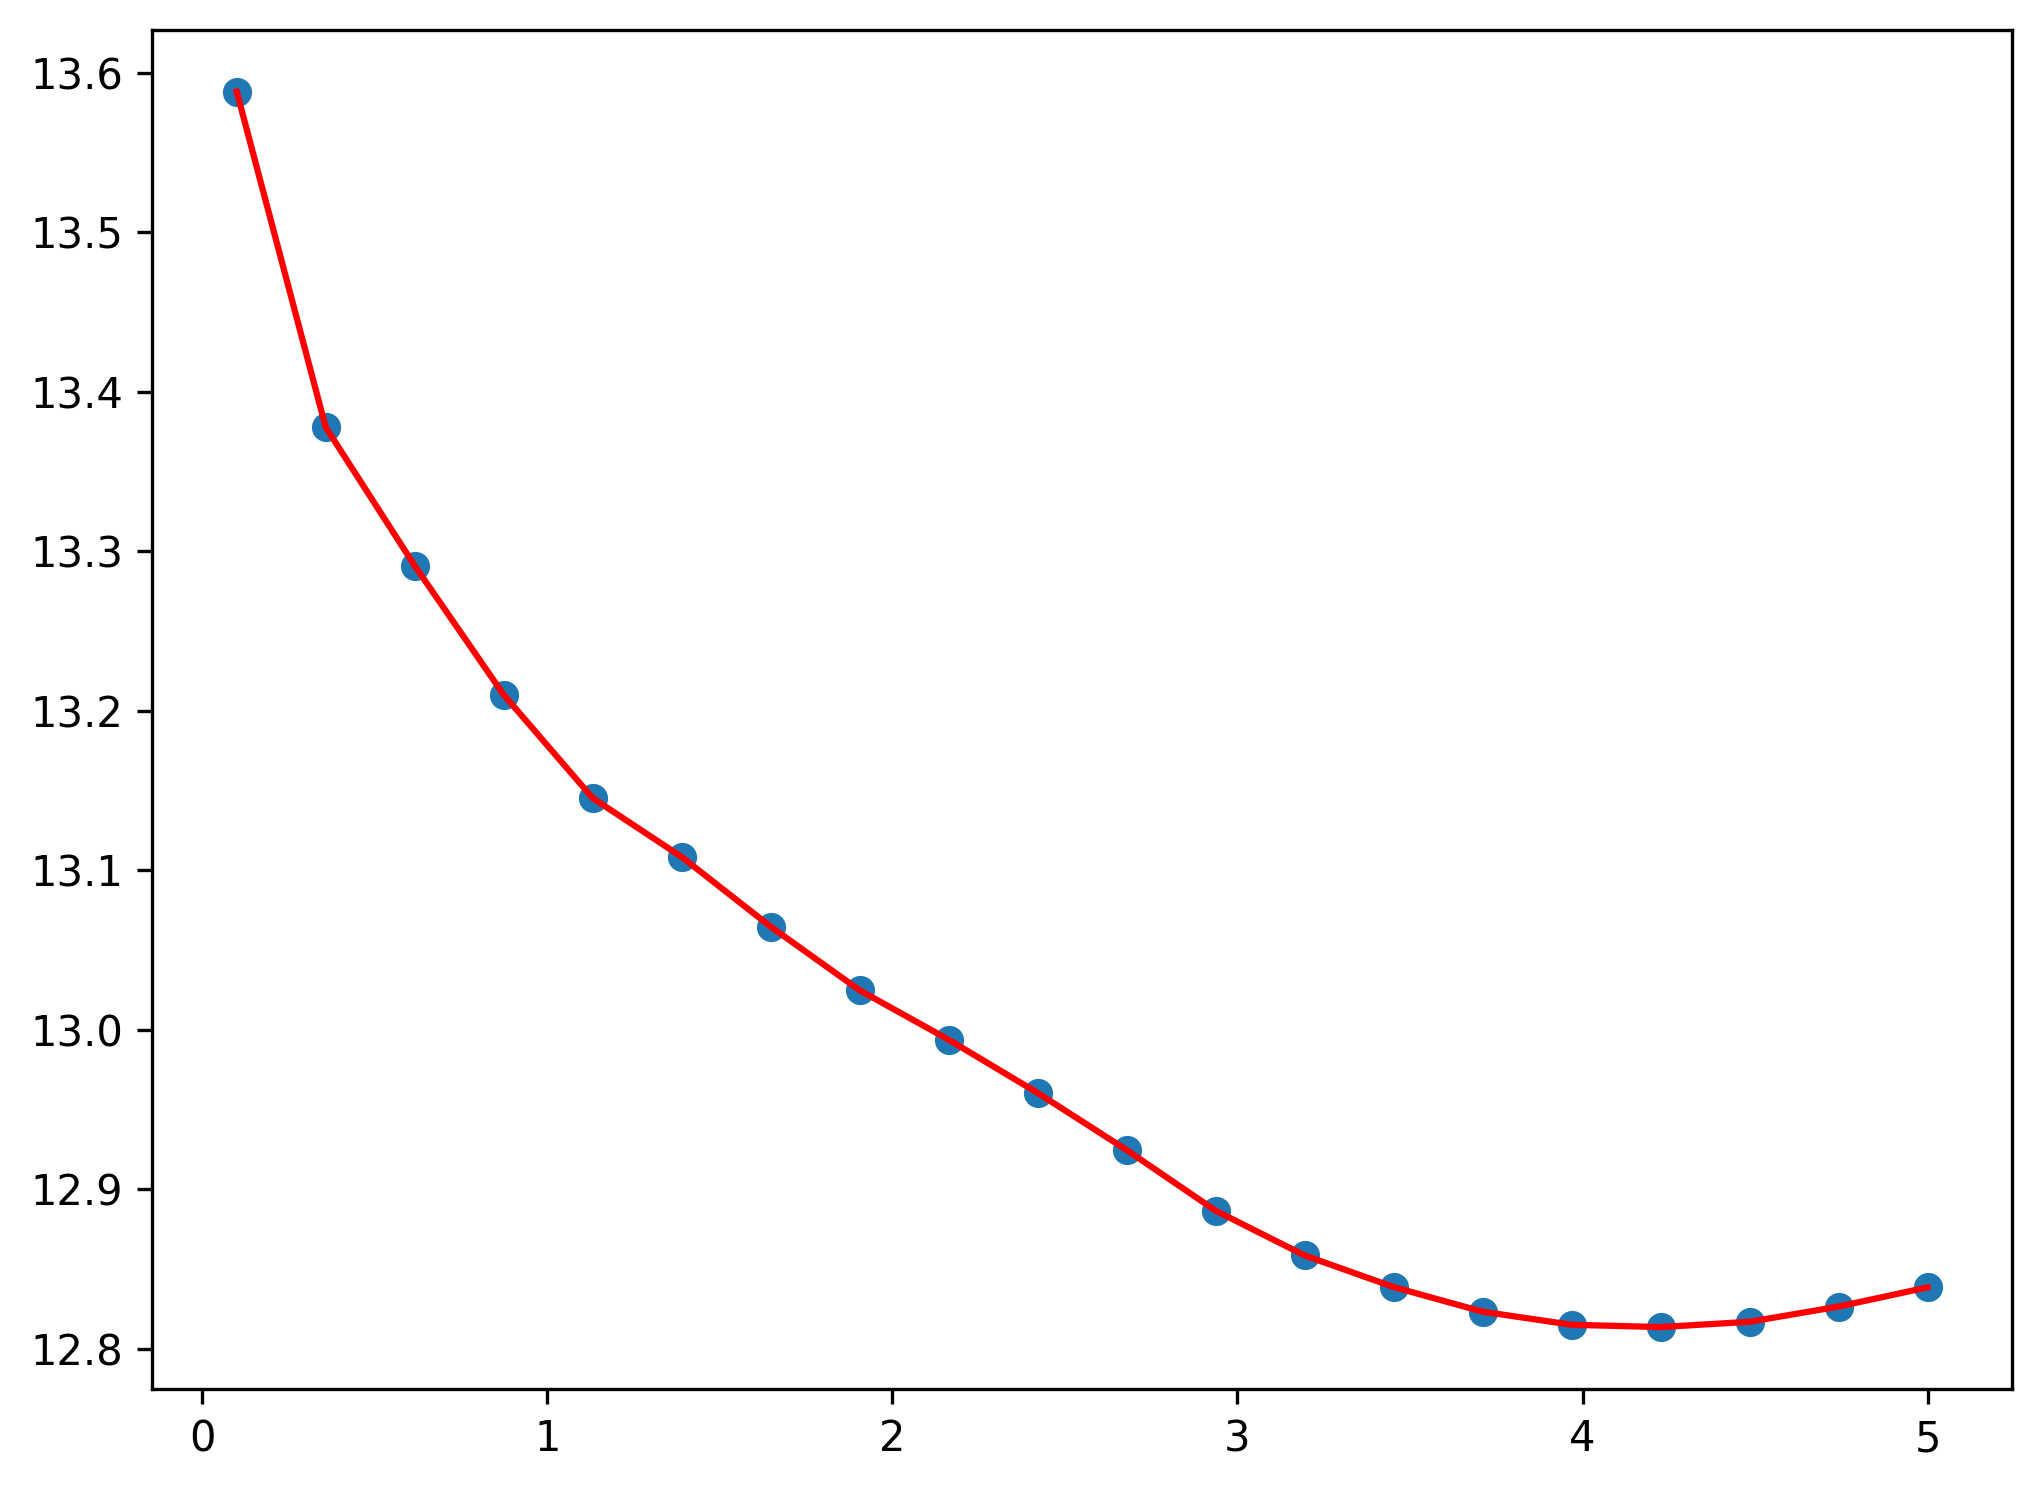

In [68]:
a_range = np.linspace(0.1,5,20) #For lasso we have no hint abobut what is the best alpha, so we have to go through many
test_mse = []
for a in a_range:
  mse = DoKFoldSqrtLasso(xs,y,a,10)
  test_mse.append(mse)
  print(a)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(a_range,test_mse)
ax.plot(a_range,test_mse,c='red')

In [69]:
best_mse = test_mse[np.argmin(test_mse)]
best_a = a_range[np.argmin(test_mse)]
print(best_a)

4.226315789473684


In [70]:
model = sm.OLS(y,xs)
result = model.fit_regularized(method='sqrt_lasso', alpha=4.226315789473684, profile_scale=True)
beta_hat = result.params
print(beta_hat)

[-9.61926949e-01  2.65622309e+00  9.59958450e-01  1.00470450e-05
 -1.82423284e+00  2.45603129e-04 -3.03443622e+00  2.02716864e+00
 -1.82520818e+00 -1.97205506e+00 -3.98127173e+00]


In [ ]:
@jit
def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part
    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))

In [ ]:
def scad_model(X,y,lam,a):
  n = X.shape[0]
  p = X.shape[1]
  # we add aan extra columns of 1 for the intercept
  #X = np.c_[np.ones((n,1)),X]
  def scad(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return 1/n*np.sum((y-X.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))
  
  def dscad(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return np.array(-2/n*np.transpose(X).dot(y-X.dot(beta))+scad_derivative(beta,lam,a)).flatten()
  b0 = np.ones((p,1))
  output = minimize(scad, b0, method='L-BFGS-B', jac=dscad,options={'gtol': 1e-8, 'maxiter': 1e7,'maxls': 25,'disp': True})
  return output.x

In [ ]:
def DoKFoldScad(X,y,lam,a,k):
  PE = []
  kf = KFold(n_splits=k,shuffle=True,random_state=1234)
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    X_train_scaled = scale.fit_transform(X_train)
    X_train_poly = poly.fit_transform(X_train_scaled)
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    X_test_scaled = scale.transform(X_test)
    X_test_poly = poly.fit_transform(X_test_scaled)
    y_test  = y[idxtest]
    beta_scad = scad_model(X_train_poly,y_train,lam,a)
    n = X_test_poly.shape[0]
    p = X_test_poly.shape[1]
    # we add an extra columns of 1 for the intercept
    #X1_test = np.c_[np.ones((n,1)),X_test]
    yhat_scad = X_test_poly.dot(beta_scad)
    PE.append(MAE(y_test,yhat_scad))
  return 1000*np.mean(PE)

In [ ]:
DoKFoldScad(X,y,0.001,1.55,10)

2503.7921511708114

## Automated approach with Particle Swarm Optimization

- INPUT: array or latice of candidate values for the hyperparameter(s)

- OUTPUT: the choice that is the cross-validated best

In [ ]:
L_test = []
L_train = []
for idxtrain, idxtest in kf.split(X):
  L_test.append(idxtest)
  L_train.append(idxtrain)

In [ ]:
L_test[2]

array([  5,   6,   9,  17,  23,  31,  32,  35,  48,  52,  60,  63,  65,
        72,  77,  80,  83,  93,  94,  95, 106, 125, 127, 132, 134, 137,
       144, 146, 147, 157, 162, 167, 168, 173, 176, 178, 179, 180, 184,
       185, 186, 193, 199, 202, 203, 206, 209, 216, 217, 222, 223, 227,
       232, 245, 248, 254, 260, 261, 271, 273, 278, 283, 289, 297, 302,
       312, 327, 330, 335, 356, 357, 360, 364, 376, 381, 382, 390, 397,
       410, 413, 414, 415, 425, 436, 439, 445, 446, 453, 455, 461, 462,
       464, 467, 468, 471, 479, 482, 488, 489, 499, 502])

In [ ]:
@jit
def SqrtLassoCV(alpha):
  PEV = []
  for i in range(len(alpha[:,0])):
    PE  = []
    a = alpha[i,0]
    for i in range(5):
      idxtrain = L_train[i]
      idxtest  = L_test[i]
      X_train = X[idxtrain,:]
      y_train = y[idxtrain]
      X_test  = X[idxtest,:]
      y_test  = y[idxtest]
      model = sm.OLS(y_train,X_train)
      result = model.fit_regularized(method='sqrt_lasso', alpha=a)
      yhat_test = result.predict(X_test)
      # mae = np.mean(np.abs(y_test-yhat_test))
      PE.append(MAE(y_test,yhat_test))
    PEV.append(np.mean(PE))
  return np.array(PEV)

In [ ]:
x_max = 20 *np.ones(1)
x_min = 0.001 * np.ones(1)
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=1, options=options, bounds=bounds)

cost, pos = optimizer.optimize(SqrtLassoCV, iters=100)

In [ ]:
yy = np.random.normal(0,1,(100,1))
yh = np.random.normal(0,1,(100,1))

In [ ]:
MAE(yy,yh)

1.1224248949316133

In [ ]:
np.mean(np.abs(yy-yh))

1.1224248949316133

## Simmulated Annealing

In [ ]:
MIN_ALPHA = 1e-3
MAX_ALPHA = 20
STEP_SIZE = 1     # Std of gaussian steps
COOLING = 0.975     # T_{n+1} = T_{n}*COOLING, i.e. geometric cooling

In [ ]:
# We already have the cost embedded into DoKFold
def random_start():
    alpha = np.random.random()*(MAX_ALPHA-MIN_ALPHA) + MIN_ALPHA
    return alpha
def random_neighbour(alpha,T):
    delta_alpha = np.random.normal()*STEP_SIZE*T
    new_alpha = min(MAX_ALPHA, max(MIN_ALPHA, alpha+delta_alpha))
    return new_alpha
def acceptance_probability(cost, new_cost, temperature):
    if new_cost < cost:
        return 1
    else:
        p = np.exp(-(new_cost - cost) / temperature)
        return p
def locate_min(a):
    smallest = min(a)
    return smallest, [index for index, element in enumerate(a) if smallest == element]

def annealing(alpha0 = random_start()):
    # Start with a random configuration
    # alpha = random_start()
    alpha = alpha0
    
    # Compute the cost function (in this case, 1-accuracy)
    cost = DoKFoldSqrtLasso(X,y,alpha)
    
    # Keep lists of results, start with the current
    states, costs = [alpha], [cost]
    T = 1
    while T > 1e-10:
        new_alpha = random_neighbour(alpha,T)
        new_cost = DoKFoldSqrtLasso(X,y,alpha=new_alpha)
        if acceptance_probability(cost, new_cost, T) > np.random.random():
            cost = new_cost
            alpha = new_alpha
            states.append(alpha)
            costs.append(cost)
        T = T*COOLING
    return model,states,costs

Lowest cost function value: 3546.35580653421
Best alpha value(s):
[0.49016785990413153]


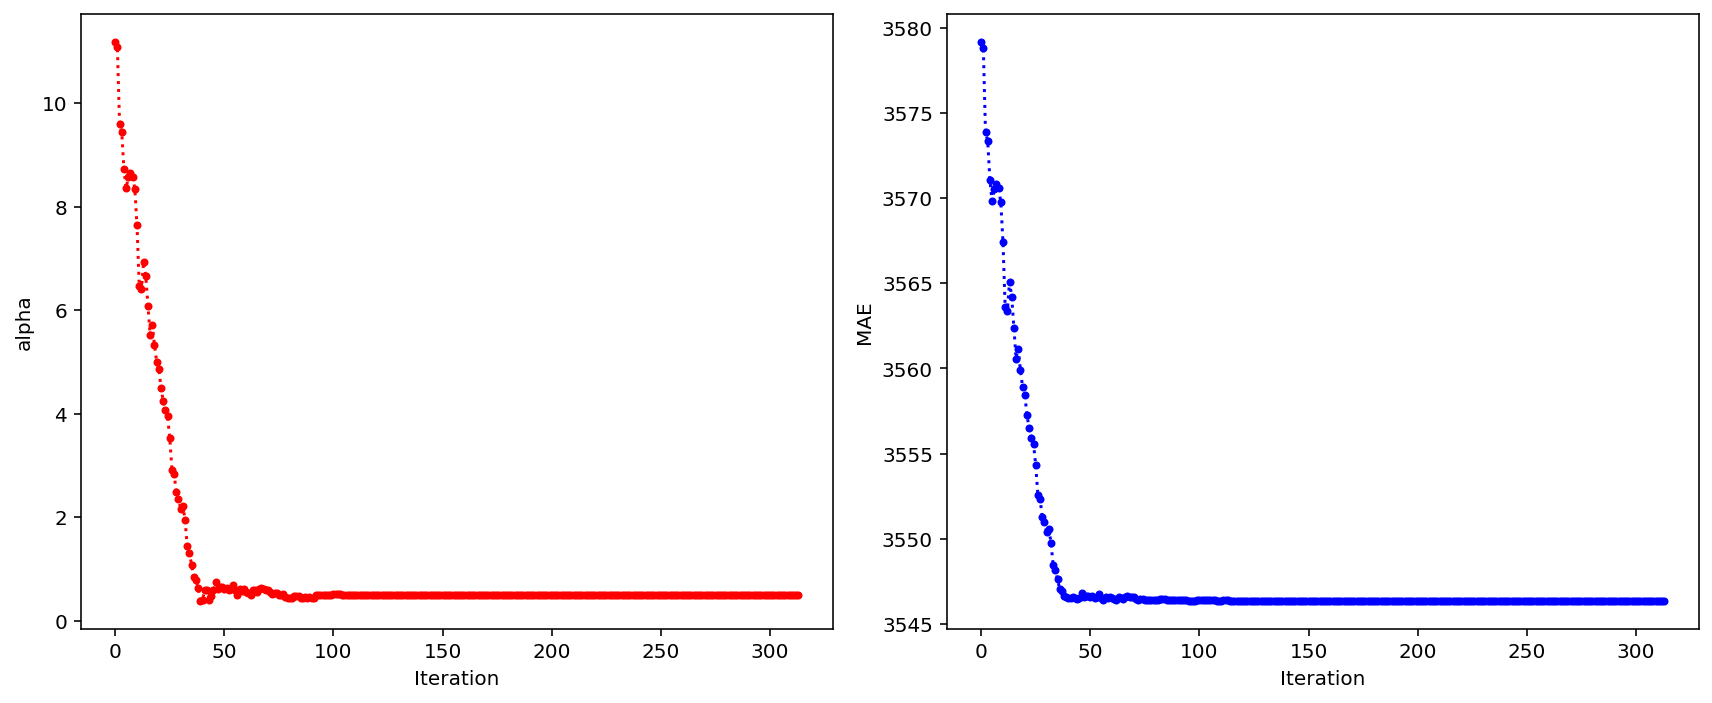

In [ ]:
model,states,costs = annealing()

lowest_cost, best_states = locate_min(costs)
print('Lowest cost function value: ' + str(lowest_cost))
print('Best alpha value(s):')
print([states[idx] for idx in best_states])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(states,':.r')
plt.xlabel('Iteration')
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(costs,':.b')
plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

In [ ]:
model  = LinearRegression()
model.fit(X,y)
model.coef_

In [ ]:
model = Lasso(alpha=0.1)
model.fit(X,y)
model.coef_

array([-0.72989416,  1.67586938,  2.5186417 ,  0.01460169,  0.16767627,
        0.        , -0.        ,  1.68780325, -0.34387493,  3.8160577 ,
        0.12751221,  0.        ,  0.06810297, -0.06883119, -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
model = ElasticNet(alpha=0.2,l1_ratio=0.75)
model.fit(X,y)
model.coef_

array([-0.39403815,  1.3998379 ,  2.20618106,  0.21584558,  0.24331836,
        0.        ,  0.        ,  1.54099904, -0.        ,  3.19358678,
        0.41944205,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        ,  0.        ])

## SCAD

In [ ]:
@jit
def scad_penalty(beta_hat, lambda_val, a_val):
    is_linear = (np.abs(beta_hat) <= lambda_val)
    is_quadratic = np.logical_and(lambda_val < np.abs(beta_hat), np.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < np.abs(beta_hat)
    
    linear_part = lambda_val * np.abs(beta_hat) * is_linear
    quadratic_part = (2 * a_val * lambda_val * np.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant
    return linear_part + quadratic_part + constant_part
    
def scad_derivative(beta_hat, lambda_val, a_val):
    return lambda_val * ((beta_hat <= lambda_val) + (a_val * lambda_val - beta_hat)*((a_val * lambda_val - beta_hat) > 0) / ((a_val - 1) * lambda_val) * (beta_hat > lambda_val))

In [ ]:
def scad_model(X,y,lam,a):
  n = X.shape[0]
  p = X.shape[1]
  # we add aan extra columns of 1 for the intercept
  X = np.c_[np.ones((n,1)),X]
  def scad(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return 1/n*np.sum((y-X.dot(beta))**2) + np.sum(scad_penalty(beta,lam,a))
  
  def dscad(beta):
    beta = beta.flatten()
    beta = beta.reshape(-1,1)
    n = len(y)
    return np.array(-2/n*np.transpose(X).dot(y-X.dot(beta))+scad_derivative(beta,lam,a)).flatten()
  b0 = np.ones((p+1,1))
  output = minimize(scad, b0, method='L-BFGS-B', jac=dscad,options={'gtol': 1e-8, 'maxiter': 1e7,'maxls': 25,'disp': True})
  return output.x

In [ ]:
scad_model(X,y,2,2)



pyswarms.single.global_best:   6%|▌         |6/100, best_cost=9.16


array([-1.35823170e-01, -1.57306693e-01,  4.63919361e+00,  9.54177909e-02,
       -1.27275656e-01, -4.38167624e-01,  1.09807143e-02, -1.41843315e+00,
       -3.68115294e-02, -4.37181483e-03,  4.09109429e-01, -4.98606069e-01])

In [ ]:
def scad_predict(X,y,lam,a):
  beta_scad = scad_model(X,y,lam,a)
  n = X.shape[0]
  p = X.shape[1]
  # we add aan extra columns of 1 for the intercept
  X = np.c_[np.ones((n,1)),X]
  return X.dot(beta_scad)

In [ ]:
def DoKFoldScad(X,y,lam,a):
  PE = []
  for idxtrain, idxtest in kf.split(X):
    X_train = X[idxtrain,:]
    y_train = y[idxtrain]
    X_test  = X[idxtest,:]
    y_test  = y[idxtest]
    beta_scad = scad_model(X_train,y_train,lam,a)
    n = X_test.shape[0]
    p = X_test.shape[1]
    # we add an extra columns of 1 for the intercept
    X1_test = np.c_[np.ones((n,1)),X_test]
    yhat_scad = X1_test.dot(beta_scad)
    PE.append(MAE(y_test,yhat_scad))
  return 1000*np.mean(PE)

In [ ]:
DoKFoldScad(X,y,0.1,1.2)

3563.3315517943674

In [ ]:
from numba import jit, prange

In [ ]:
@jit
def ScadCV(hparam):
  PEV = []
  for i in prange(len(hparam[:,0])):
    for j in prange(len(hparam[:,1])):
      PE  = []
      for idxtrain, idxtest in kf.split(X):
        X_train = X[idxtrain,:]
        y_train = y[idxtrain]
        X_test  = X[idxtest,:]
        y_test  = y[idxtest]
        beta_scad = scad_model(X_train,y_train,hparam[i,0],hparam[j,1])
        n = X_test.shape[0]
        p = X_test.shape[1]
        # we add an extra columns of 1 for the intercept
        X1_test = np.c_[np.ones((n,1)),X_test]
        yhat_scad = X1_test.dot(beta_scad)
        PE.append(MAE(y_test,yhat_scad))
    PEV.append(np.mean(PE))
  return np.array(PEV)

In [ ]:
x_max = np.array([2, 2])
x_min = np.array([0.001, 1.0001])
bounds = (x_min, x_max)
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=2, options=options, bounds=bounds)

cost, pos = optimizer.optimize(ScadCV, iters=70)

pyswarms.single.global_best: 100%|██████████|70/70, best_cost=3.48
2021-03-12 18:31:29,736 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.4778452007773084, best pos: [0.01053186 1.54210738]


In [ ]:
x_max 

array([2, 2])

In [ ]:
x_max = np.array([2, 2])

In [ ]:
%%time
model = ElasticNet()
params = [{'alpha':np.linspace(0.001,1,num=50),'l1_ratio':np.linspace(0,1,num=50)}]
gs = GridSearchCV(estimator=model,cv=10,scoring='neg_mean_squared_error',param_grid=params)
gs_results = gs.fit(X,y)
print(gs_results.best_params_)
print('The mean square error is: ', np.abs(gs_results.best_score_))

## Example of Stepwise Regression

In [ ]:
# Implementation of stepwise regression
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details """
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

## Ranking Variables (this is relative to the context/model)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=310, max_depth=10,n_estimators=100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=310, verbose=0, warm_start=False)

In [ ]:
df.drop('cmedv',axis=1)

In [ ]:
model.fit(X,y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=310, verbose=0, warm_start=False)

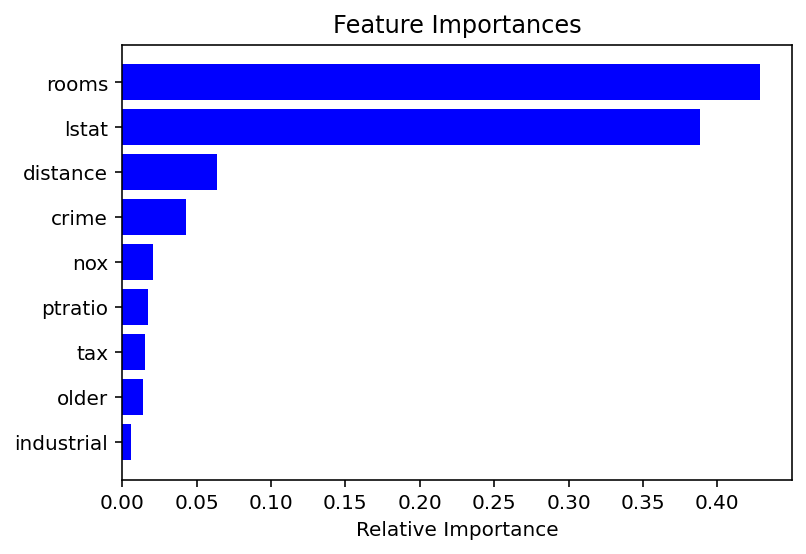

In [ ]:
features = Xdf.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()